# Correlations between Google Search Volumes of COVID-19 symptoms and infections in Germany over the course of the pandemic

**by Christian Görner**

---

**General Imports**

In [5]:
from pytrends.request import TrendReq
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

---

**The RKI Dataset**

The RKI Dataset is retrieved from 
https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74
on 3 Jan 2022

Description may be found here:
https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/about

The Dataset contains reportings from german health authorities on a county ('Landkreis') level. One row represents a number of deaths, confirmed and recovered cases for a certain group of people (divided by gender, age group etc).

The Dataset will be breifly analyzed and Fields unnecessary for this research are removed. The first preprocessing step results in a Dataframe with accumulated new cases and deaths per day in Germany.

In [6]:
# Load Data
rki = pd.read_csv('RKI_COVID19.csv')
rki.head(3)

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2021/04/08 00:00:00,1001,"03.01.2022, 00:00 Uhr",0,-9,2021/04/08 00:00:00,0,1,1,Nicht übermittelt
1,2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2021/04/08 00:00:00,1001,"03.01.2022, 00:00 Uhr",0,-9,2021/04/08 00:00:00,0,1,0,Nicht übermittelt
2,3,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2021/04/09 00:00:00,1001,"03.01.2022, 00:00 Uhr",0,-9,2021/04/07 00:00:00,0,1,1,Nicht übermittelt


In [7]:
# inspect types
rki.dtypes

FID                      int64
IdBundesland             int64
Bundesland              object
Landkreis               object
Altersgruppe            object
Geschlecht              object
AnzahlFall               int64
AnzahlTodesfall          int64
Meldedatum              object
IdLandkreis              int64
Datenstand              object
NeuerFall                int64
NeuerTodesfall           int64
Refdatum                object
NeuGenesen               int64
AnzahlGenesen            int64
IstErkrankungsbeginn     int64
Altersgruppe2           object
dtype: object

In [8]:
# normalize Date format
rki['Meldedatum'] = pd.to_datetime(rki['Meldedatum'])

In [9]:
# check for NAs
rki.isna().sum()

FID                     0
IdBundesland            0
Bundesland              0
Landkreis               0
Altersgruppe            0
Geschlecht              0
AnzahlFall              0
AnzahlTodesfall         0
Meldedatum              0
IdLandkreis             0
Datenstand              0
NeuerFall               0
NeuerTodesfall          0
Refdatum                0
NeuGenesen              0
AnzahlGenesen           0
IstErkrankungsbeginn    0
Altersgruppe2           0
dtype: int64

In [10]:
# remove unnecessary columns, write into new DataFrame
rki_ger = rki.drop(
    columns = ['IdBundesland', 'Bundesland', 'Landkreis', 
               'Altersgruppe', 'Geschlecht', 'IdLandkreis', 
               'Datenstand', 'Refdatum', 'NeuGenesen', 
               'AnzahlGenesen', 'IstErkrankungsbeginn', 
               'Altersgruppe2', 'NeuerTodesfall', 'NeuerFall', 'FID', 'AnzahlTodesfall']
)

In [11]:
# Set the Reported date as index and sort the DataFrame
rki_ger = rki_ger.set_index('Meldedatum').sort_index()

# Sum up all Rows per Day
rki_ger = rki_ger.resample('D').sum()
rki_ger.tail(3)

,AnzahlFall
Meldedatum,
2021-12-31,25378
2022-01-01,11798
2022-01-02,8225


---

**Google Trends**
with pytrends

This section will introduce the pytrends package, with which the Google Trends Data will be retrieved.
The Google Trends API will be requested for each given keyword.

For this research, the german Language, timezone and geolocation will be configured, so the results are shown for exactly this specification.

This section results in a method to retrieve information from GT API for a desired set of keywords in a given timespan.

A documentation to pytrends can be found here: https://pypi.org/project/pytrends/

In [12]:
# Instanciate pytrends, set language to german and timezone to +60 minutes.
pytrends = TrendReq(hl='de-DE', tz=60)

In [13]:
# Return Dataframe with search interest for given keywords in a given timespan
# Default geolocation is Germany, no category is specified. 
# More on categories here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories
# Note: isPartial Column is dropped since all results are accumulated into one DF
def getGoogleTrends(keywords, date_from, date_until):
    timeframe = date_from + ' ' + date_until
    
    collection = []
    for keyword in keywords:
        pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='DE')
        trends = pytrends.interest_over_time()
        trends = trends.drop(columns=['isPartial'])
        collection.append(trends)

    return pd.concat(collection, axis=1)

<AxesSubplot:xlabel='date'>

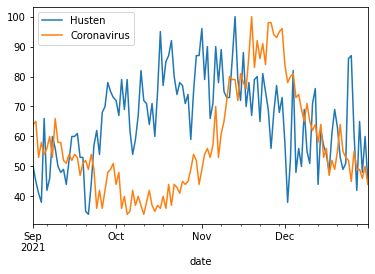

In [14]:
# Do a little show-run for the german translation of 'cough' and the term 'coronavirus'

keywords = [ 'Husten', 'Coronavirus']
getGoogleTrends(keywords, '2021-09-01', '2021-12-31').plot()

---

**Combine the Data**

This preprocessing step will combine both data sources to one dataframe for the given timespan. 
This will ease further analysis.

First, the GT dataframe is concatenated with the RKI dataframe. 
In a second step, the RKI-Data is smoothened by writing the mean of a 7-day window (default). This is due to a high fluctuation in daily new cases at this dataset, as seen in the plots below. 
If wished so, the GT data also may be smoothened by a custom value.
Then, NA values are removed, leaving only the rows where RKI and GT data is available, 
so automatically cropping the dataset to the desired timeframe used before.

In the end, the RKI values are normalized to the 0-100 scale Google Trends uses.

<AxesSubplot:xlabel='Meldedatum'>

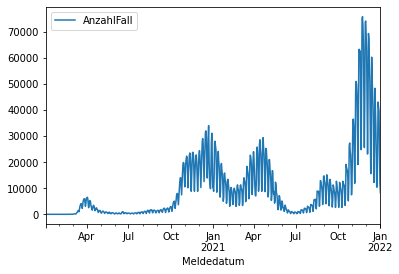

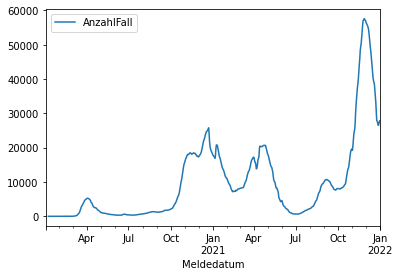

In [15]:
# Showing the difference between the original and smoothened RKI-Dataset.
rki_ger.plot()
rki_ger.rolling(7).mean().plot()

In [16]:
# Return a dataframe with preprocessed and normalized gt and rki data
def getCombinedDF(rki_df, gt_df, rki_mean = 7, gt_mean = None):
    if (rki_mean):
        rki_df = rki_df.rolling(rki_mean).mean()
        
    if (gt_mean):
        gt_df = gt_df.rolling(gt_mean).mean()
        
    combined = pd.concat([rki_df, gt_df], axis=1)
    combined = combined.dropna()
    
    combined['AnzahlFall'] = combined['AnzahlFall'] / combined['AnzahlFall'].max() * 100
    
    return combined

---

**Perform a Time Lagged Cross Correlation**

This section provides a function to perform a Time Lagged Cross Correlation on the dataFrame given a certain offset.

The Function iterates each keyword and performs an inner loop for each covid-19 metric. For each of those combinations, multiple correlation calculations are performed (pearson), shifting the keyword time series on the x-axis by a given range, e.g. from -30 days to +30 days.  
The best of these correlations is saved with the best offset calculated.

The function returns a Dataframe with the combination names, the correlation coefficient and the offset of the keyword-timeseries in days. Also, a rating of the correlation is performed, by stating if the coefficient was inside a specified thereshold.

In [17]:
#Time Lagged Cross Correlation

def calcCrossCorrelation(df, keywords, days_offset, thereshold = 0.6):
    results = pd.DataFrame(columns=['keyword', 'r', 'days_offset', 'is_relevant'])
    
    for keyword in keywords:
        cross_correlations = []
        for lag in range(-days_offset, days_offset):
            cross_correlations.append(df['AnzahlFall'].corr(df[keyword].shift(lag)))
        offset = np.argmax(cross_correlations)-np.floor(len(cross_correlations)/2)
        r = df['AnzahlFall'].corr(df[keyword].shift(int(offset)))

        relevant = True if ((r < -thereshold) or (r > thereshold)) else False
        new_row = {'keyword': keyword, 'r':r, 'days_offset':offset, 'is_relevant':relevant}
        results = results.append(new_row,ignore_index=True)
    return results


---

**Retrieve Data and perform analysis**

This part will cover the actual data gathering (google trends) and the calculation of the correlations.

First, a Keyword set is defined, containing the Keywords given by the german Robert Koch Institute.
https://www.rki.de/DE/Content/Gesundheitsmonitoring/Gesundheitsberichterstattung/GBEDownloadsJ/JoHM_S11_2020_Krankheitsschwere_COVID_19.pdf?__blob=publicationFile

It contains all of the keywords given by the RKI:  
Husten (Cough), Fieber (fever), Schnupfen (rhinitis), Störung des Geruchs- und/oder Geschmackssinns (disturbance of sense of smell and/or taste)\*, Halsschmerzen (sore throat), Atemnot (shortness of breath), Kopfschmerzen (headache), Gliederschmerzen (aching limbs), 
Appetitlosigkeit (loss of appetite), Gewichtsverlust (weight loss), Übelkeit (nausea), Bauchschmerzen (abdominal pain), 
Erbrechen (Vomiting), Durchfall (diarrhoea), Konjunktivitis (conjunctivitis), Hautausschlag (skin rash), 
Lymphknotenschwellung (Lymph node swelling), Apathie (apathy), Somnolenz (somnolence).

\* verwendet als Geschmacksverlust, Geruchsverlust (used as loss of taste, loss of smell)

This Analysis is performed on 4 different Timeframes of 6 months each, starting from 08 Jan 2020 until 31 Dec 2021.  
The data is retrieved and the correlations are calculated for each batch.

In [18]:
keywords = ['Husten', 'Fieber', 'Schnupfen', 'Geruchsverlust', 'Geschmacksverlust', 'Halsschmerzen', 'Atemnot', 'Kopfschmerzen', 'Gliederschmerzen', 'Appetitlosigkeit', 'Gewichtsverlust', 'Übelkeit', 'Erbrechen', 'Durchfall', 'Konjunktivitis', 'Hautausschlag', 'Lymphknotenschwellung', 'Apathie', 'Somnolenz']

In [19]:
date_from_01_2020 = '2019-12-19' #hack to get full frame also with means. Doesn't work here since RKI data starts at 08 Jan
date_until_01_2020 = '2020-05-31'
df_01_2020 = getCombinedDF(rki_ger, getGoogleTrends(keywords, date_from_01_2020, date_until_01_2020),7,14)

In [20]:
date_from_02_2020 = '2020-05-19'
date_until_02_2020 = '2020-12-31'
df_02_2020 = getCombinedDF(rki_ger, getGoogleTrends(keywords, date_from_02_2020, date_until_02_2020),7,14)

In [21]:
date_from_01_2021 = '2020-12-19'
date_until_01_2021 = '2021-05-31'
df_01_2021 = getCombinedDF(rki_ger, getGoogleTrends(keywords, date_from_01_2021, date_until_01_2021),7,14)

In [22]:
date_from_02_2021 = '2021-05-19'
date_until_02_2021 = '2021-12-31'
df_02_2021 = getCombinedDF(rki_ger, getGoogleTrends(keywords, date_from_02_2021, date_until_02_2021),7,14)

In [23]:
df_01_2020

,AnzahlFall,Husten,Fieber,Schnupfen,Geruchsverlust,Geschmacksverlust,Halsschmerzen,Atemnot,Kopfschmerzen,Gliederschmerzen,Appetitlosigkeit,Gewichtsverlust,Übelkeit,Erbrechen,Durchfall,Konjunktivitis,Hautausschlag,Lymphknotenschwellung,Apathie,Somnolenz
2020-01-08,0.002705,44.285714,26.214286,36.071429,2.714286,3.928571,37.571429,22.642857,50.142857,30.785714,30.785714,36.642857,63.142857,58.571429,70.928571,15.428571,48.642857,18.428571,23.500000,6.571429
2020-01-09,0.000000,42.857143,26.785714,34.428571,2.714286,3.928571,36.642857,22.642857,49.928571,31.142857,30.142857,33.785714,63.428571,56.928571,69.571429,13.071429,48.500000,14.285714,25.857143,6.571429
2020-01-10,0.000000,41.500000,27.071429,32.642857,2.714286,3.928571,35.000000,22.142857,49.785714,25.857143,31.214286,35.785714,61.928571,51.857143,67.357143,15.000000,47.642857,12.428571,25.571429,6.571429
2020-01-11,0.000000,40.857143,27.285714,33.071429,5.428571,3.928571,34.000000,23.071429,49.571429,24.214286,29.642857,35.642857,62.000000,51.785714,68.357143,12.642857,46.785714,12.428571,25.357143,6.571429
2020-01-12,0.000000,39.714286,27.285714,32.500000,5.428571,1.857143,32.214286,24.285714,50.142857,23.285714,24.214286,37.642857,61.714286,54.000000,67.571429,10.428571,43.857143,12.428571,25.142857,6.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,8.590749,18.428571,18.571429,14.785714,11.500000,10.214286,17.928571,27.785714,56.285714,21.857143,21.785714,27.071429,43.500000,34.571429,57.357143,17.571429,57.714286,4.571429,20.071429,15.428571
2020-05-28,8.888288,18.785714,18.428571,14.571429,11.500000,10.214286,18.000000,28.428571,57.928571,20.142857,19.714286,31.928571,43.642857,34.000000,57.857143,14.142857,59.571429,4.571429,17.928571,15.500000
2020-05-29,8.671896,18.642857,18.500000,14.785714,11.500000,10.214286,17.642857,27.000000,56.214286,19.000000,17.500000,31.000000,42.857143,33.500000,58.000000,8.928571,59.357143,4.571429,17.928571,15.500000
2020-05-30,8.771977,17.500000,18.785714,14.642857,11.500000,8.285714,17.571429,24.928571,53.428571,21.142857,17.500000,31.000000,43.428571,32.571429,59.071429,11.071429,60.428571,4.571429,17.928571,22.642857


In [24]:
cc_01_2020 = calcCrossCorrelation(df_01_2020, keywords, 35)
cc_01_2020

,keyword,r,days_offset,is_relevant
0,Husten,0.753005,15.0,True
1,Fieber,0.769321,17.0,True
2,Schnupfen,0.813936,17.0,True
3,Geruchsverlust,0.774011,-7.0,True
4,Geschmacksverlust,0.904625,2.0,True
5,Halsschmerzen,0.909611,14.0,True
6,Atemnot,0.970202,3.0,True
7,Kopfschmerzen,0.884968,11.0,True
8,Gliederschmerzen,0.753851,15.0,True
9,Appetitlosigkeit,0.519257,34.0,False


In [25]:
cc_02_2020 = calcCrossCorrelation(df_02_2020, keywords, 35)
cc_02_2020

,keyword,r,days_offset,is_relevant
0,Husten,0.837979,34.0,True
1,Fieber,0.572347,34.0,False
2,Schnupfen,0.417392,34.0,False
3,Geruchsverlust,0.923665,-7.0,True
4,Geschmacksverlust,0.944811,18.0,True
5,Halsschmerzen,0.571054,34.0,False
6,Atemnot,0.687728,-7.0,True
7,Kopfschmerzen,0.818836,34.0,True
8,Gliederschmerzen,0.921489,30.0,True
9,Appetitlosigkeit,0.094493,-13.0,False


In [26]:
cc_01_2021 = calcCrossCorrelation(df_01_2021, keywords, 35)
cc_01_2021

,keyword,r,days_offset,is_relevant
0,Husten,0.706815,7.0,True
1,Fieber,0.702059,14.0,True
2,Schnupfen,0.817185,10.0,True
3,Geruchsverlust,0.460842,-10.0,False
4,Geschmacksverlust,0.227481,-14.0,False
5,Halsschmerzen,0.808563,8.0,True
6,Atemnot,0.653641,-5.0,True
7,Kopfschmerzen,0.570572,19.0,False
8,Gliederschmerzen,0.693799,15.0,True
9,Appetitlosigkeit,0.523147,-27.0,False


In [27]:
cc_02_2021 = calcCrossCorrelation(df_02_2021, keywords, 35)
cc_02_2021

,keyword,r,days_offset,is_relevant
0,Husten,0.924184,27.0,True
1,Fieber,0.189697,8.0,False
2,Schnupfen,0.813317,34.0,True
3,Geruchsverlust,0.846491,3.0,True
4,Geschmacksverlust,0.955454,-3.0,True
5,Halsschmerzen,0.858115,34.0,True
6,Atemnot,-0.503315,3.0,False
7,Kopfschmerzen,-0.332357,-31.0,False
8,Gliederschmerzen,0.700770,-20.0,True
9,Appetitlosigkeit,-0.059413,-15.0,False


---

**Accumulate results**  


The correlations are now compared to each other.

Therefore, all relevant metrics are put together into one DF.  
Then, variance, standard deviation and the sum of "accepted correlations" are calculated. The table is sorted accordingly.

In [28]:
# combine all correlation tables to one DF

cc_combined = cc_01_2020.copy()
cc_combined = cc_combined.rename(columns={'r':'r_01_2020', 'days_offset':'days_offset_01_2020', 'is_relevant':'is_relevant_01_2020'})
cc_combined['r_02_2020'] = cc_02_2020['r']
cc_combined['days_offset_02_2020'] = cc_02_2020['days_offset']
cc_combined['is_relevant_02_2020'] = cc_02_2020['is_relevant']
cc_combined['r_01_2021'] = cc_01_2021['r']
cc_combined['days_offset_01_2021'] = cc_01_2021['days_offset']
cc_combined['is_relevant_01_2021'] = cc_01_2021['is_relevant']
cc_combined['r_02_2021'] = cc_02_2021['r']
cc_combined['days_offset_02_2021'] = cc_02_2021['days_offset']
cc_combined['is_relevant_02_2021'] = cc_02_2021['is_relevant']


cc_combined

,keyword,r_01_2020,days_offset_01_2020,is_relevant_01_2020,r_02_2020,days_offset_02_2020,is_relevant_02_2020,r_01_2021,days_offset_01_2021,is_relevant_01_2021,r_02_2021,days_offset_02_2021,is_relevant_02_2021
0,Husten,0.753005,15.0,True,0.837979,34.0,True,0.706815,7.0,True,0.924184,27.0,True
1,Fieber,0.769321,17.0,True,0.572347,34.0,False,0.702059,14.0,True,0.189697,8.0,False
2,Schnupfen,0.813936,17.0,True,0.417392,34.0,False,0.817185,10.0,True,0.813317,34.0,True
3,Geruchsverlust,0.774011,-7.0,True,0.923665,-7.0,True,0.460842,-10.0,False,0.846491,3.0,True
4,Geschmacksverlust,0.904625,2.0,True,0.944811,18.0,True,0.227481,-14.0,False,0.955454,-3.0,True
5,Halsschmerzen,0.909611,14.0,True,0.571054,34.0,False,0.808563,8.0,True,0.858115,34.0,True
6,Atemnot,0.970202,3.0,True,0.687728,-7.0,True,0.653641,-5.0,True,-0.503315,3.0,False
7,Kopfschmerzen,0.884968,11.0,True,0.818836,34.0,True,0.570572,19.0,False,-0.332357,-31.0,False
8,Gliederschmerzen,0.753851,15.0,True,0.921489,30.0,True,0.693799,15.0,True,0.700770,-20.0,True
9,Appetitlosigkeit,0.519257,34.0,False,0.094493,-13.0,False,0.523147,-27.0,False,-0.059413,-15.0,False


In [29]:
def calcStd(array):
    return np.std(array)

def countTrue(array):
    return sum(array)



cc_combined['r_std'] = cc_combined.apply(lambda x: calcStd([x['r_01_2020'], x['r_02_2020'],x['r_01_2021'],x['r_02_2021']]), axis=1)
cc_combined['relevance_count'] = cc_combined.apply(lambda x: countTrue([x['is_relevant_01_2020'], x['is_relevant_02_2020'],x['is_relevant_01_2021'],x['is_relevant_02_2021']]), axis=1)

In [30]:
cc_combined.sort_values(by=['relevance_count', 'r_std'], ascending=[False, True])


,keyword,r_01_2020,days_offset_01_2020,is_relevant_01_2020,r_02_2020,days_offset_02_2020,is_relevant_02_2020,r_01_2021,days_offset_01_2021,is_relevant_01_2021,r_02_2021,days_offset_02_2021,is_relevant_02_2021,r_std,relevance_count
0,Husten,0.753005,15.0,True,0.837979,34.0,True,0.706815,7.0,True,0.924184,27.0,True,0.083119,4
8,Gliederschmerzen,0.753851,15.0,True,0.921489,30.0,True,0.693799,15.0,True,0.700770,-20.0,True,0.091902,4
5,Halsschmerzen,0.909611,14.0,True,0.571054,34.0,False,0.808563,8.0,True,0.858115,34.0,True,0.129604,3
2,Schnupfen,0.813936,17.0,True,0.417392,34.0,False,0.817185,10.0,True,0.813317,34.0,True,0.172095,3
3,Geruchsverlust,0.774011,-7.0,True,0.923665,-7.0,True,0.460842,-10.0,False,0.846491,3.0,True,0.175822,3
4,Geschmacksverlust,0.904625,2.0,True,0.944811,18.0,True,0.227481,-14.0,False,0.955454,-3.0,True,0.306935,3
6,Atemnot,0.970202,3.0,True,0.687728,-7.0,True,0.653641,-5.0,True,-0.503315,3.0,False,0.565108,3
16,Lymphknotenschwellung,0.663810,23.0,True,0.526522,-35.0,False,0.643560,-31.0,True,0.354590,-35.0,False,0.122891,2
14,Konjunktivitis,0.662967,5.0,True,0.413732,-35.0,False,0.783972,34.0,True,0.441341,-35.0,False,0.154336,2
1,Fieber,0.769321,17.0,True,0.572347,34.0,False,0.702059,14.0,True,0.189697,8.0,False,0.224311,2


---

**Plot Area**

<AxesSubplot:>

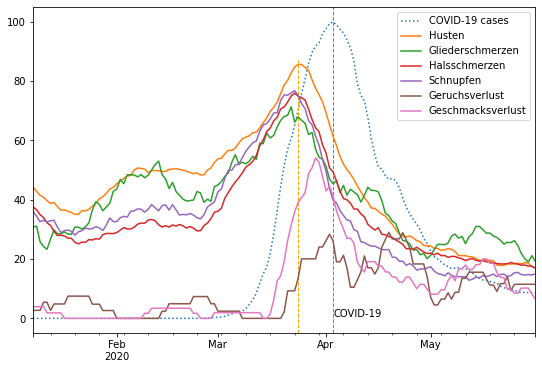

In [31]:
#Google Trends relative search volume for selected keywords and the normalized COVID-19 infections from 08 Jan 2020 until 31 May 2020
ax = plt.gca()
df_01_2020.plot(y='AnzahlFall', label='COVID-19 cases' ,style=':', figsize=(9,6), ax=ax)
ax.axvline(df_01_2020['AnzahlFall'].idxmax(), ymax = df_01_2020['AnzahlFall'].max(), color='grey', linestyle='--', lw=1)
plt.text(df_01_2020['AnzahlFall'].idxmax(), .5, 'COVID-19')

df_01_2020.plot(y='Husten',ax=ax)
ax.axvline(df_01_2020['Husten'].idxmax(), ymax = df_01_2020['Husten'].max()/100-.02, color='orange', linestyle='--', lw=1)

df_01_2020.plot(y='Gliederschmerzen', ax=ax)
df_01_2020.plot(y='Halsschmerzen', ax=ax)
df_01_2020.plot(y='Schnupfen',ax=ax)
df_01_2020.plot(y='Geruchsverlust', ax=ax)
df_01_2020.plot(y='Geschmacksverlust', ax=ax)

<AxesSubplot:>

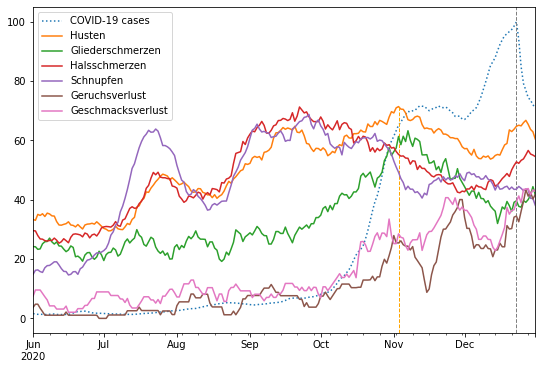

In [32]:
ax = plt.gca()
df_02_2020.plot(y='AnzahlFall', label='COVID-19 cases' ,style=':', figsize=(9,6), ax=ax)
ax.axvline(df_02_2020['AnzahlFall'].idxmax(), ymax = df_02_2020['AnzahlFall'].max(), color='grey', linestyle='--', lw=1)
#plt.text(df_02_2020['AnzahlFall'].idxmax(), .5, 'COVID-19')

df_02_2020.plot(y='Husten',ax=ax)
ax.axvline(df_02_2020['Husten'].idxmax(), ymax = df_02_2020['Husten'].max()/100-.02, color='orange', linestyle='--', lw=1)

df_02_2020.plot(y='Gliederschmerzen', ax=ax)
df_02_2020.plot(y='Halsschmerzen', ax=ax)
df_02_2020.plot(y='Schnupfen',ax=ax)
df_02_2020.plot(y='Geruchsverlust', ax=ax)
df_02_2020.plot(y='Geschmacksverlust', ax=ax)

<AxesSubplot:>

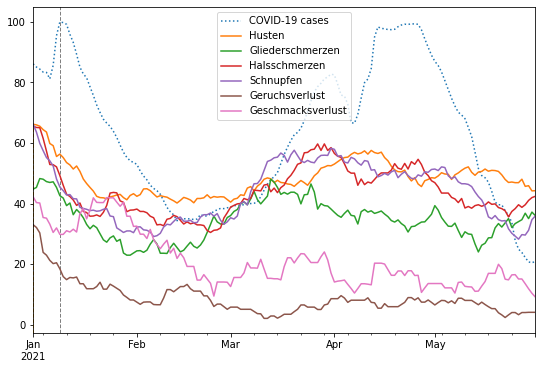

In [33]:
ax = plt.gca()
df_01_2021.plot(y='AnzahlFall', label='COVID-19 cases' ,style=':', figsize=(9,6), ax=ax)
ax.axvline(df_01_2021['AnzahlFall'].idxmax(), ymax = df_01_2021['AnzahlFall'].max(), color='grey', linestyle='--', lw=1)
#plt.text(df_01_2021['AnzahlFall'].idxmax(), .5, 'COVID-19')

df_01_2021.plot(y='Husten',ax=ax)
ax.axvline(df_01_2021['Husten'].idxmax(), ymax = df_01_2021['Husten'].max()/100-.02, color='orange', linestyle='--', lw=1)

df_01_2021.plot(y='Gliederschmerzen', ax=ax)
df_01_2021.plot(y='Halsschmerzen', ax=ax)
df_01_2021.plot(y='Schnupfen',ax=ax)
df_01_2021.plot(y='Geruchsverlust', ax=ax)
df_01_2021.plot(y='Geschmacksverlust', ax=ax)

<AxesSubplot:>

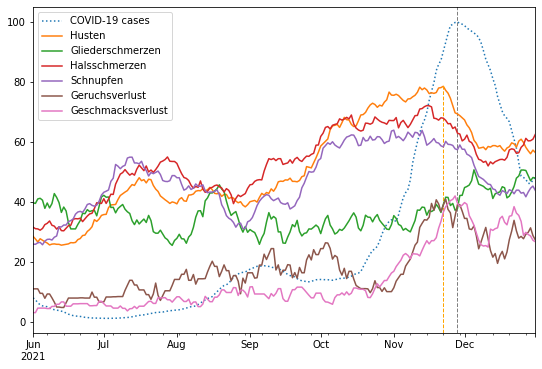

In [34]:
ax = plt.gca()
df_02_2021.plot(y='AnzahlFall', label='COVID-19 cases' ,style=':', figsize=(9,6), ax=ax)
ax.axvline(df_02_2021['AnzahlFall'].idxmax(), ymax = df_02_2021['AnzahlFall'].max(), color='grey', linestyle='--', lw=1)
#plt.text(df_02_2021['AnzahlFall'].idxmax(), .5, 'COVID-19')

df_02_2021.plot(y='Husten',ax=ax)
ax.axvline(df_02_2021['Husten'].idxmax(), ymax = df_02_2021['Husten'].max()/100-.02, color='orange', linestyle='--', lw=1)

df_02_2021.plot(y='Gliederschmerzen', ax=ax)
df_02_2021.plot(y='Halsschmerzen', ax=ax)
df_02_2021.plot(y='Schnupfen',ax=ax)
df_02_2021.plot(y='Geruchsverlust', ax=ax)
df_02_2021.plot(y='Geschmacksverlust', ax=ax)